###Import all the libraries

In [ ]:
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import statistics as st
import math
import statsmodels.api as sm

## Import SKlearn libraries for Data processing and model building

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


## Settting the initial parametesrs for visualization
plt.rcdefaults()
plt.rcParams['figure.figsize']=(12,5)
plt.rc('axes',grid=True,facecolor='#E6E6E6',edgecolor='none')
plt.rc('grid',color='w',linestyle='solid')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)


## Import warning libraries to ignore warning messages
import warnings
warnings.filterwarnings("ignore")




Requirement already satisfied: xgboost in /databricks/python3/lib/python3.8/site-packages (1.6.1)
Requirement already satisfied: numpy in /databricks/python3/lib/python3.8/site-packages (from xgboost) (1.22.4)
Requirement already satisfied: scipy in /databricks/python3/lib/python3.8/site-packages (from xgboost) (1.6.2)
 WARNING: You are using pip version 21.0.1; however, version 22.1.2 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [ ]:
## Reading the data set
data = pd.read_csv("/dbfs/FileStore/Shimon/Meters.csv")



In [ ]:
## Display the list of columns
data.columns

Out[22]: Index(['METER_SERIAL_NUMBER', 'METER_MODEL', 'REGION_NAME', 'CITY_NAME',
 'MANUFACTURER', 'METER_INSTALL_DATE', 'TO_TIME', 'Income',
 'CUSTOMER_TYPE_3-Room Households', 'CUSTOMER_TYPE_4-Room Households',
 'CUSTOMER_TYPE_5-Room Households', 'month', 'temp', 'consump'],
 dtype='object')

In [ ]:
## Descriptive statistics of the numerical variables
data[["Income","temp","consump"]].describe()

Out[23]:

,Income,temp,consump
count,553588.000000,553588.000000,553067.000000
mean,9764.046671,24.198489,48.754153
std,1707.883174,13.823318,179.063303
min,7347.530000,-5.000000,0.000000
25%,9241.920000,14.000000,27.000000
50%,9334.340000,26.000000,35.000000
75%,9711.860000,36.000000,43.000000
max,15662.150000,44.000000,3099.000000


In [ ]:
## Creating addtional variables and adding holidays information to the data

data['TO_TIME'] = pd.to_datetime(data['TO_TIME'])
data['month'] = data['TO_TIME'].dt.month


## Categorizing months into Hot, Cold and Standard categories
Cold_month = [11,12,1,2]
Hot_month = [6,7,8,9,10]
Std_month = [3,4,5]


## Creating a season variable based on the above created categories
data['season'] = ""

data['season'] = np.where(data['month'].isin(Cold_month),"cold",data['season'])
data['season'] = np.where(data['month'].isin(Hot_month),"hot",data['season'])
data['season'] = np.where(data['month'].isin(Std_month),"std",data['season'])

data['day'] = data['TO_TIME'].dt.day_name()
data['day'].unique()


## Creating a weekend variable

weekends = ['Saturday','Friday']

hols=['2021-01-28','2021-02-25','2021-02-26','2021-03-27','2021-03-28','2021-04-03','2021-04-04','2021-04-14','2021-04-15',
      '2021-04-30','2021-05-16','2021-05-17','2021-09-06','2021-09-07','2021-09-08','2021-09-15','2021-09-16','2021-09-20','2021-09-21']


data['weekends'] = np.where(data['day'].isin(weekends),1,0)
data['weekends'] = np.where(data['TO_TIME'].astype('str').isin(hols),1,data['weekends'])
data['consump'] = np.where(data['weekends']==1,data['consump']+10,data['consump'])




Out[25]:

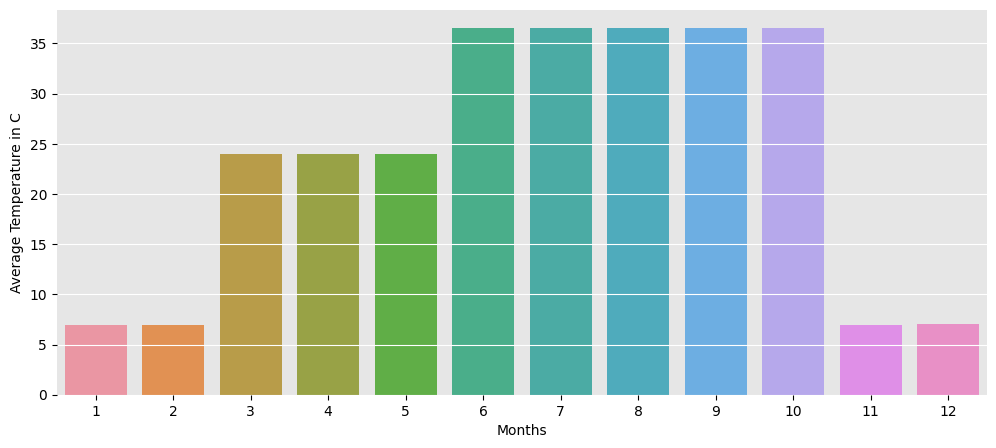

Text(0.5, 0, 'Months')

In [ ]:
## Displaying Average temperature over all the months

plot_data_1 = pd.DataFrame(data.groupby('month')['temp'].mean()).reset_index()
ax = sns.barplot(data=plot_data_1,x='month',y='temp')
ax.set_ylabel("Average Temperature in C")
ax.set_xlabel("Months")

Out[26]:

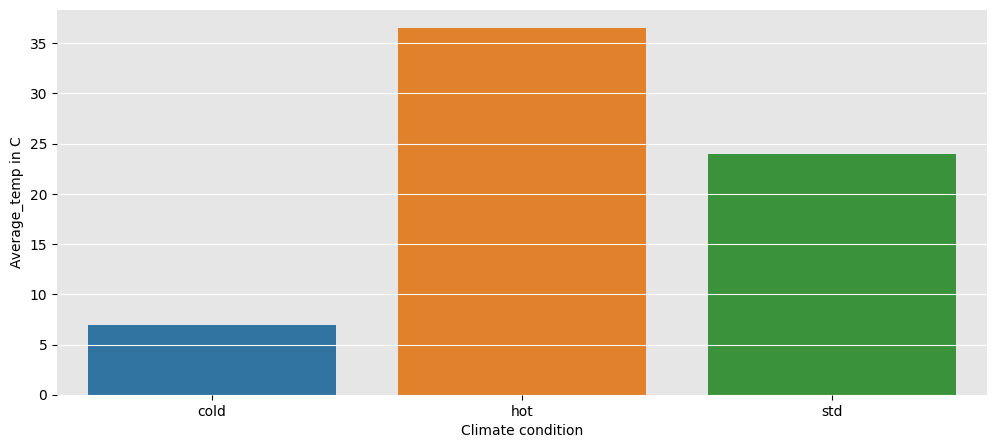

Text(0.5, 0, 'Climate condition')

In [ ]:
## Average temperature in different season

plot_data_1 = pd.DataFrame(data.groupby('season')['temp'].mean()).reset_index()
ax = sns.barplot(data=plot_data_1,x='season',y='temp')
ax.set_ylabel("Average_temp in C")
ax.set_xlabel("Climate condition")

Out[27]:

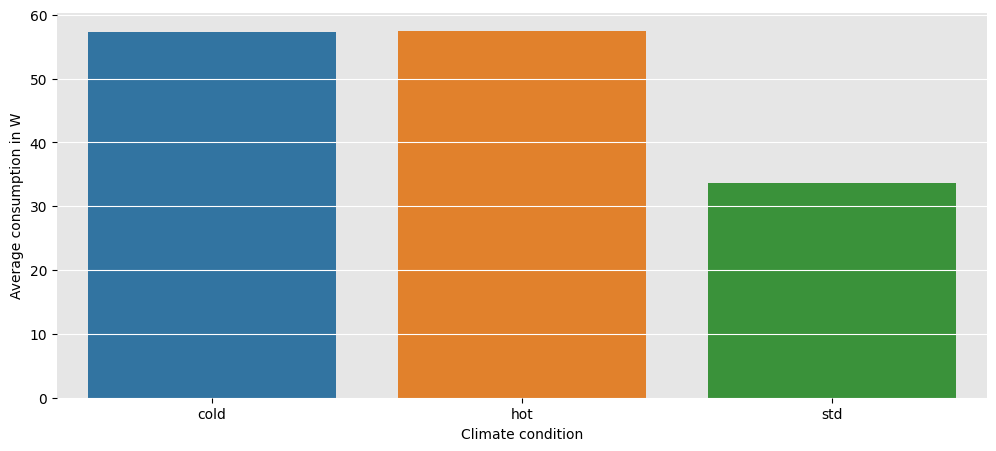

Text(0.5, 0, 'Climate condition')

In [ ]:
## Average consumption in different climate condition

plot_data_2 = pd.DataFrame(data.groupby('season')['consump'].mean()).reset_index()
ax = sns.barplot(data=plot_data_2,x='season',y='consump')
ax.set_ylabel("Average consumption in W")
ax.set_xlabel("Climate condition")

Out[28]:

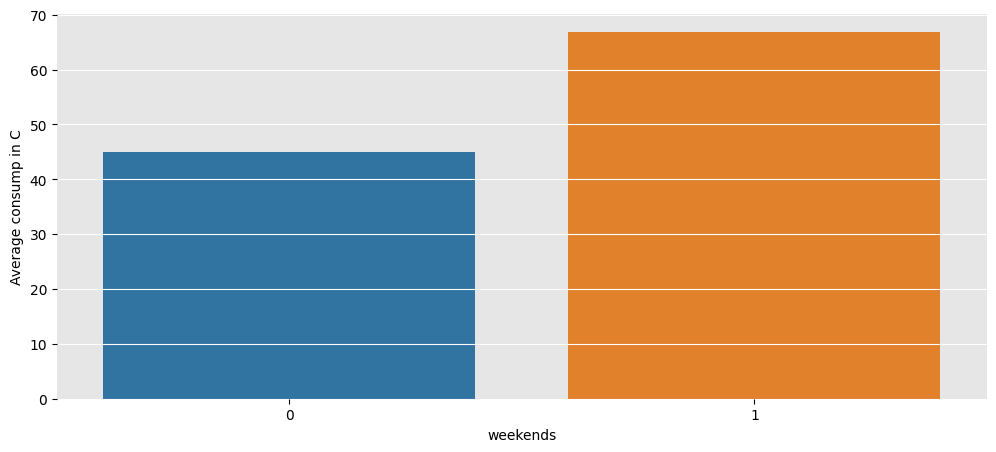

Text(0.5, 0, 'weekends')

In [ ]:
## Average consumption over weekends

plot_data_3 = pd.DataFrame(data.groupby('weekends')['consump'].mean()).reset_index()
ax = sns.barplot(data=plot_data_3,x='weekends',y='consump')
ax.set_ylabel("Average consump in C")
ax.set_xlabel("weekends")

In [ ]:
## Importing KNN imputer to inmpute missing data
from sklearn.impute import KNNImputer

import time
start = time.process_time()


imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(data[['consump', 'temp','weekends']])

# your code here    
print(time.process_time() - start)
data['consump'] = imputed_data.T[0]

53.893020259

In [ ]:
## Removing Outliers using IQR method

q3 = data['consump'].quantile(0.75)
q1 = data['consump'].quantile(0.25)
iqr = q3 - q1

up_dur = q3 + (1.5*iqr)

print(up_dur)

73.0

In [ ]:
df = data[data['consump']< up_dur]

Out[32]:

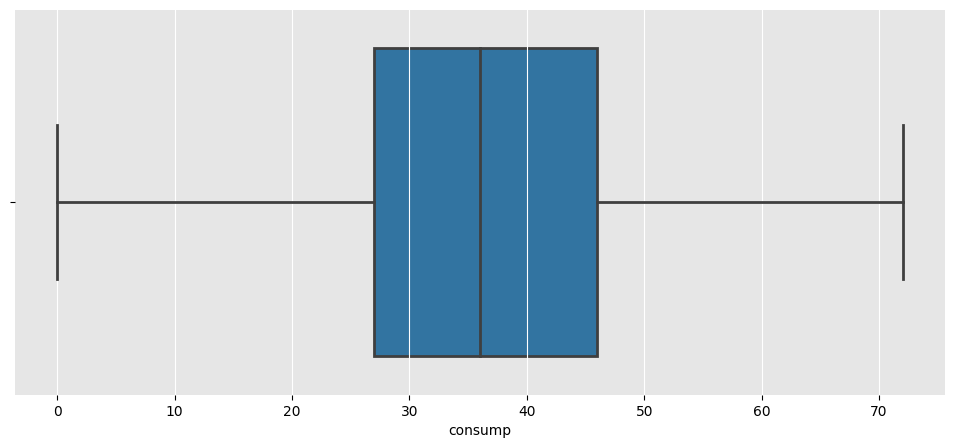

<AxesSubplot:xlabel='consump'>

In [ ]:
## Distribution of consumption after removing outliers

sns.boxplot(df['consump'])

Out[33]:

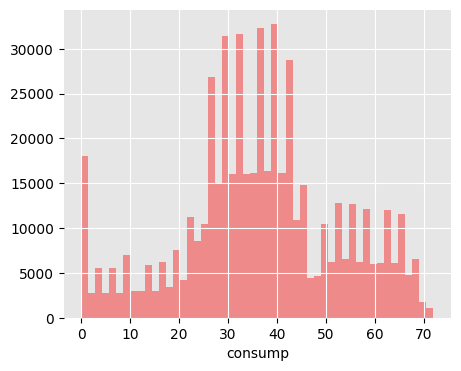

<AxesSubplot:xlabel='consump'>

In [ ]:
plt.rcParams['figure.figsize']=(5,4)
sns.distplot(df['consump'],kde=False,color='red')

In [ ]:
## Creating customer type variable

dum = df[['CUSTOMER_TYPE_3-Room Households','CUSTOMER_TYPE_4-Room Households','CUSTOMER_TYPE_5-Room Households','consump','weekends','month']]
dum['cust_type'] = np.nan
dum['cust_type'] = np.where(dum['CUSTOMER_TYPE_3-Room Households']==1,'3-Room',dum['cust_type'])
dum['cust_type'] = np.where(dum['CUSTOMER_TYPE_4-Room Households']==1,'4-Room',dum['cust_type'])
dum['cust_type'] = np.where(dum['CUSTOMER_TYPE_5-Room Households']==1,'5-Room',dum['cust_type'])

Out[35]:

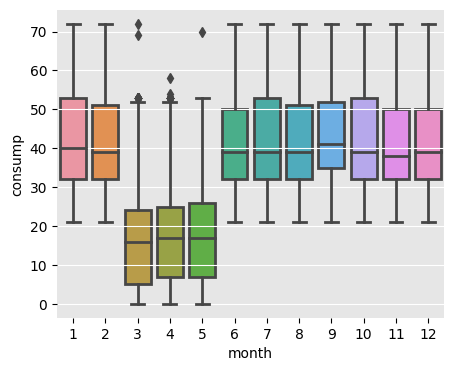

<AxesSubplot:xlabel='month', ylabel='consump'>

In [ ]:
sns.boxplot(data = dum , x = "month", y='consump')

In [ ]:
## performing one hot encoding for all the categorical variable

dummy = df[["CITY_NAME","MANUFACTURER",'season']]
dummy_data = pd.get_dummies(dummy)

model_data = pd.concat([dummy_data,df[["Income","temp","weekends","consump","CUSTOMER_TYPE_3-Room Households","CUSTOMER_TYPE_4-Room Households",
                                      "CUSTOMER_TYPE_5-Room Households","month"]]],axis=1)

### Data Modelling

In [ ]:
## Random sampling the dataset to create train - test split

sample = model_data.sample(frac=0.3).reset_index(drop=True)
# X=data.drop(['CONSUMPTION'],axis=1)
X=sample[['CITY_NAME_Azor', 'CITY_NAME_Beer-Sheva', 'CITY_NAME_Beit Shemesh',
       'CITY_NAME_Harish', 'CITY_NAME_Jerusalem', 'CITY_NAME_Kiryat Bialik',
       'CITY_NAME_Modiin', 'CITY_NAME_Netanya', 'CITY_NAME_Rosh HaAyin',
       'CITY_NAME_Tel-Aviv', 'CITY_NAME_Tiberias', 'CITY_NAME_Tirat Carmel',
       'CUSTOMER_TYPE_3-Room Households', 'CUSTOMER_TYPE_4-Room Households',
       'CUSTOMER_TYPE_5-Room Households', 'MANUFACTURER_KAIFA',
       'MANUFACTURER_ZIV', 'temp','Income', 'weekends','month']]
Y = sample['consump'].values

sc = StandardScaler()
X_sc =  sc.fit_transform(X)

X_train,x_test,Y_train,y_test = train_test_split(X_sc,Y,test_size=0.2,random_state=12)

### Building XGboost model

In [ ]:
## Hyper performance tuning

param1 = {
  
  'learning_rate' : [0.01,0.05,0.1,0.15,0.2],
   'n_estimators' : [5,10,20,30,40,60],
   'max_depth' : [2,4,6,8,10,12]
}

xgb = XGBRegressor(objective='reg:squarederror',eval_metric='mae')

gs_xgb = GridSearchCV(param_grid=param1,estimator=xgb,n_jobs=-1,verbose=1,cv=2)
gs_xgb.fit(X_train,Y_train)
gs_xgb.best_params_

Fitting 2 folds for each of 180 candidates, totalling 360 fits
Out[38]: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 30}

Out[39]:

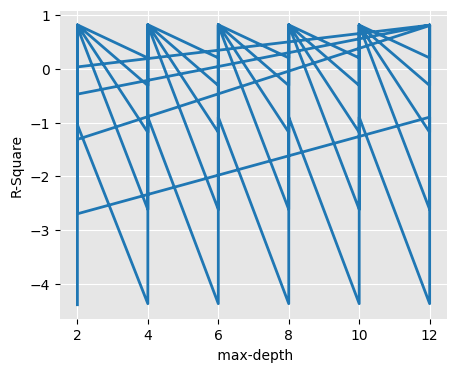

Text(0, 0.5, 'R-Square')

In [ ]:
## Max -depth vs R-square

xg=pd.DataFrame(gs_xgb.cv_results_)
plt.plot(xg['param_max_depth'],xg['mean_test_score'])
plt.xlabel(" max-depth")
plt.ylabel('R-Square')

In [ ]:
## Prediction and Accuracy metrics

xgb_mod = XGBRegressor(max_depth=4,objective='reg:squarederror',n_estimators=60,learning_rate=0.1)

xgb_mod.fit(X_train,Y_train)
y_pred = xgb_mod.predict(x_test)

print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.8170383883334879
5.808211961917839
6.934561075236226

### Random Forest

In [ ]:
## Hyper parameter tuning

rf= RandomForestRegressor()

param_grid={
  
   'n_estimators' : [5,10,20,30,40,50,60,70],
    'max_depth': [5,10,15,20,25,30],
   'max_features':['auto','sqrt']
#   'min_samples_split': [200],
#   'min_samples_leaf': [100],
#   'criterion':['mae']
  
}

grid_search = GridSearchCV(estimator = rf,param_grid = param_grid,cv=2,verbose=1,scoring = 'r2',n_jobs=-1)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 2 folds for each of 96 candidates, totalling 192 fits
Out[41]: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 30}

Out[42]:

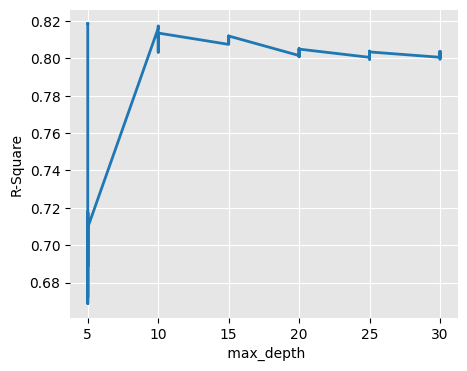

Text(0, 0.5, 'R-Square')

In [ ]:
rf=pd.DataFrame(grid_search.cv_results_)
plt.plot(rf['param_max_depth'],rf['mean_test_score'])
plt.xlabel(" max_depth")
plt.ylabel('R-Square')

In [ ]:
rf = RandomForestRegressor(max_features='auto',max_depth=5, n_estimators=60,verbose=1,n_jobs=-1,random_state=2)
rf.fit(X_train, Y_train)
y_pred = rf.predict(x_test)

print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 10 tasks | elapsed: 0.2s
[Parallel(n_jobs=-1)]: Done 60 out of 60 | elapsed: 0.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 10 tasks | elapsed: 0.0s
[Parallel(n_jobs=20)]: Done 60 out of 60 | elapsed: 0.0s finished
0.8168903843772197
5.808181605579261
6.937365311020241

### Feature importance using Random Forest

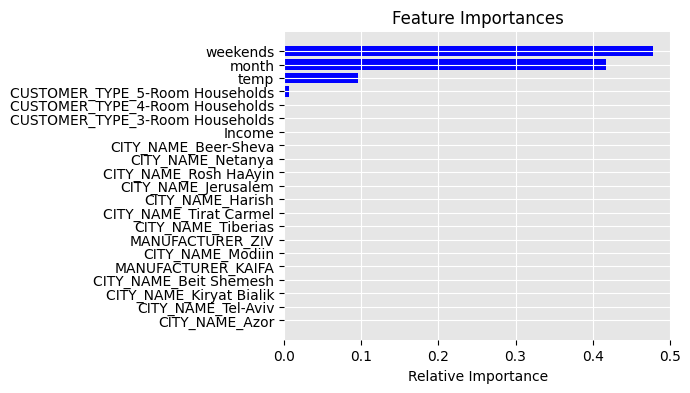

In [ ]:
features = ['CITY_NAME_Azor', 'CITY_NAME_Beer-Sheva', 'CITY_NAME_Beit Shemesh',
       'CITY_NAME_Harish', 'CITY_NAME_Jerusalem', 'CITY_NAME_Kiryat Bialik',
       'CITY_NAME_Modiin', 'CITY_NAME_Netanya', 'CITY_NAME_Rosh HaAyin',
       'CITY_NAME_Tel-Aviv', 'CITY_NAME_Tiberias', 'CITY_NAME_Tirat Carmel',
       'CUSTOMER_TYPE_3-Room Households', 'CUSTOMER_TYPE_4-Room Households',
       'CUSTOMER_TYPE_5-Room Households', 'MANUFACTURER_KAIFA',
       'MANUFACTURER_ZIV', 'temp','Income', 'weekends','month']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Decision tree

In [ ]:
DTR=DecisionTreeRegressor()

param_grid={
  
#    'n_estimators' : [5,10,20,30,40,50,60,70],
    'max_depth': [5,10,15,20,25,30],
  'min_samples_split':[2,5,10,15,20,25]
#    'max_features':['auto','sqrt']
#   'min_samples_split': [200],
#   'min_samples_leaf': [100],
#   'criterion':['mae']
  
}

grid_search = GridSearchCV(estimator = DTR,param_grid = param_grid,cv=2,verbose=1,scoring = 'r2',n_jobs=-1)

grid_search.fit(X_train, Y_train)
grid_search.best_params_

Fitting 2 folds for each of 36 candidates, totalling 72 fits
Out[45]: {'max_depth': 5, 'min_samples_split': 20}

Out[46]:

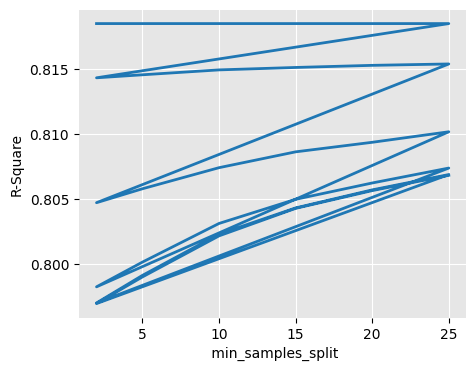

Text(0, 0.5, 'R-Square')

In [ ]:
dt=pd.DataFrame(grid_search.cv_results_)
plt.plot(dt['param_min_samples_split'],dt['mean_test_score'])
plt.xlabel(" min_samples_split")
plt.ylabel('R-Square')

In [ ]:
DTR=DecisionTreeRegressor(max_depth=5,min_samples_split=2)

# model_ada = AdaBoostRegressor(base_estimator=DTR,n_estimators=50,learning_rate=0.15)
DTR.fit(X_train, Y_train)
y_pred = DTR.predict(x_test)
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.8168407194989717
5.808170698172654
6.938306059114972

Out[48]:

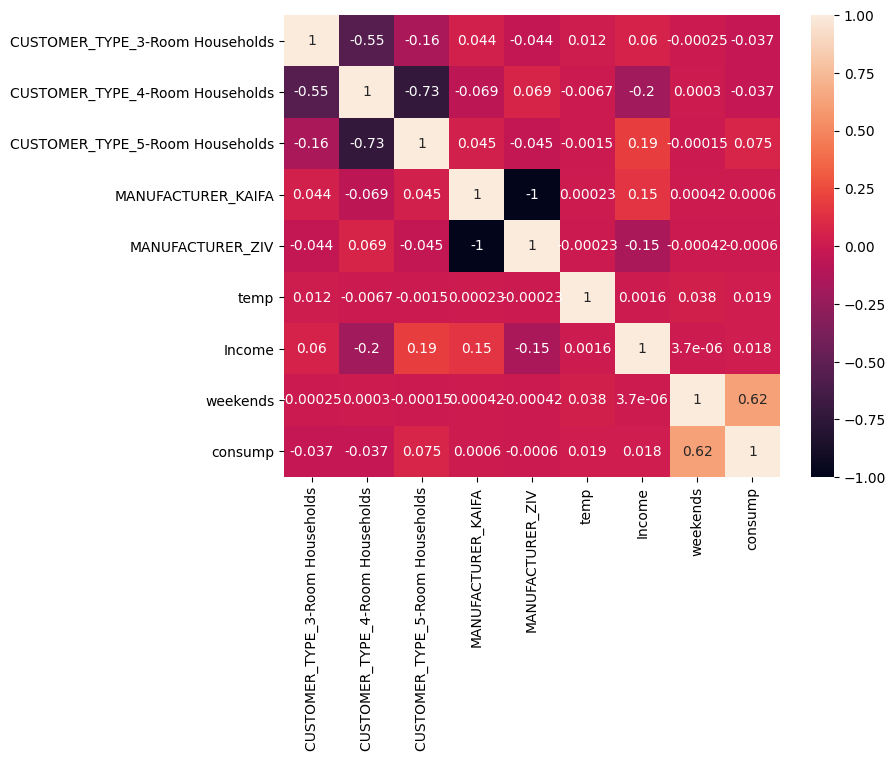

<AxesSubplot:>

In [ ]:
## Understanding the correralation plot

weather_data = model_data[['CUSTOMER_TYPE_3-Room Households', 'CUSTOMER_TYPE_4-Room Households',
       'CUSTOMER_TYPE_5-Room Households', 'MANUFACTURER_KAIFA',
       'MANUFACTURER_ZIV', 'temp','Income', 'weekends','consump']]
plt.subplots(figsize=(8,6))
sns.heatmap(weather_data.corr(),annot=True)

### Neural Networks

In [ ]:
!!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adadelta,Adagrad,Adam,SGD,RMSprop
from tensorflow.keras.layers import Dense, BatchNormalization,Activation,Dropout
from tensorflow.keras.models import Sequential

def build_ANN_Tor():
  
  ## instantiate
  mod = Sequential()
  
  # input layer
  mod.add(Dense(10, input_shape = (X_train.shape[1],)))
  
  # Hidden layer - 1
  mod.add(Dense(50, Activation('relu')))
  
  # Hidden layer - 2
  mod.add(Dense(50,Activation('relu')))
  
  # op layer
  
  mod.add(Dense(1,Activation('linear')))
  
  mod.compile(loss = "mse",optimizer=RMSprop(learning_rate=0.01), metrics=['mae','mse','mape'])
  
  return(mod)


model = build_ANN_Tor()

model.summary()
  
  
  
  

Model: "sequential"
_________________________________________________________________
 Layer (type) Output Shape Param # 
=================================================================
 dense (Dense) (None, 10) 220 
 
 dense_1 (Dense) (None, 50) 550 
 
 dense_2 (Dense) (None, 50) 2550 
 
 dense_3 (Dense) (None, 1) 51 
 
=================================================================
Total params: 3,371
Trainable params: 3,371
Non-trainable params: 0
_________________________________________________________________

In [ ]:
## Inital parameters to train Neural networks
size = 64
steps = X_train.shape[0]/size

ANN_mod =  model.fit(X_train,Y_train,epochs = 40,steps_per_epoch=steps,batch_size = size,validation_data=(x_test,y_test),shuffle=True)

Epoch 1/40
 1/2054 [..............................] - ETA: 27:18 - loss: 1425.8176 - mae: 33.4993 - mse: 1425.8176 - mape: 49069240.0000 26/2054 [..............................] - ETA: 4s - loss: 351.6693 - mae: 13.9570 - mse: 351.6693 - mape: 540200832.0000  51/2054 [..............................] - ETA: 4s - loss: 246.8038 - mae: 11.6693 - mse: 246.8038 - mape: 557582016.0000 75/2054 [>.............................] - ETA: 4s - loss: 202.5433 - mae: 10.5775 - mse: 202.5433 - mape: 546719104.0000 100/2054 [>.............................] - ETA: 4s - loss: 177.8189 - mae: 9.9658 - mse: 177.8189 - mape: 507981184.0000  127/2054 [>.............................] - ETA: 3s - loss: 161.4001 - mae: 9.5601 - mse: 161.4001 - mape: 512728192.0000 154/2054 [=>............................] - ETA: 3s - loss: 150.8136 - mae: 9.2938 - mse: 150.8136 - mape: 513189600.0000 181/2054 [=>............................] - ETA: 3s - loss: 143.1646 - mae: 9.1081 - mse: 143.1646 - mape: 501499680.0000 209/2054 [==>...........................] - ETA: 3s - loss: 136.2958 - mae: 8.9231 - mse: 136.2958 - mape: 484946304.0000 237/2054 [==>...........................] - ETA: 3s - loss: 130.8074 - mae: 8.7668 - mse: 130.8074 - mape: 482259488.0000 261/2054 [==>...........................] - ETA: 3s - loss: 126.6506 - mae: 8.6440 - mse: 126.6506 - mape: 477862336.0000 287/2054 [===>..........................] - ETA: 3s - loss: 122.8206 - mae: 8.5307 - mse: 122.8206 - mape: 466319776.0000 314/2054 [===>..........................] - ETA: 3s - loss: 119.4966 - mae: 8.4229 - mse: 119.4966 - mape: 454169184.0000 340/2054 [===>..........................] - ETA: 3s - loss: 116.3814 - mae: 8.3223 - mse: 116.3814 - mape: 447611744.0000 365/2054 [====>.........................] - ETA: 3s - loss: 113.7380 - mae: 8.2396 - mse: 113.7380 - mape: 434589632.0000 390/2054 [====>.........................] - ETA: 3s - loss: 111.4693 - mae: 8.1657 - mse: 111.4693 - mape: 429111072.0000 417/2054 [=====>........................] - ETA: 3s - 

Out[51]:

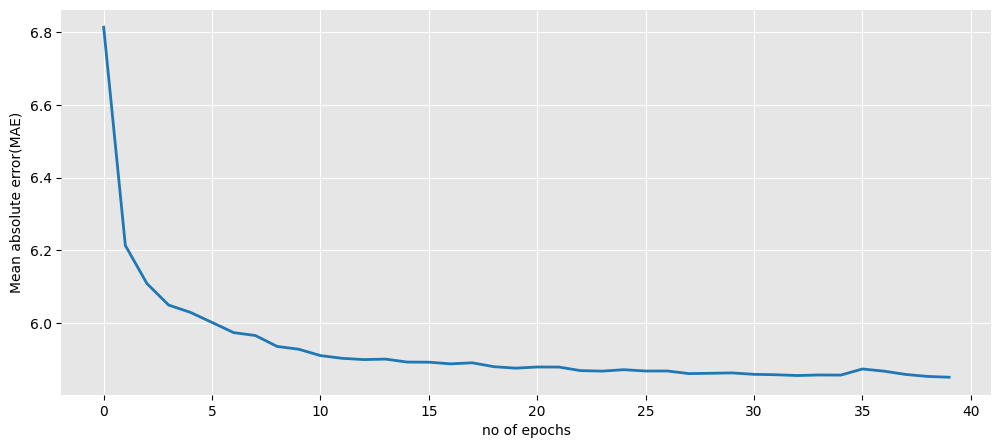

Text(0, 0.5, 'Mean absolute error(MAE)')

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize']=(12,5)
plt.rc('axes',grid=True,facecolor='#E6E6E6',edgecolor='none')
plt.rc('grid',color='w',linestyle='solid')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

plt.plot(ANN_mod.epoch,ANN_mod.history.get('mae'))
plt.xlabel("no of epochs")
plt.ylabel("Mean absolute error(MAE)")

In [ ]:
## Prediction part

y_pred = model.predict(x_test)

print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

1/1028 [..............................] - ETA: 1:34 42/1028 [>.............................] - ETA: 1s  83/1028 [=>............................] - ETA: 1s 124/1028 [==>...........................] - ETA: 1s 165/1028 [===>..........................] - ETA: 1s 206/1028 [=====>........................] - ETA: 1s 249/1028 [======>.......................] - ETA: 0s 286/1028 [=======>......................] - ETA: 0s 326/1028 [========>.....................] - ETA: 0s 365/1028 [=========>....................] - ETA: 0s 402/1028 [==========>...................] - ETA: 0s 442/1028 [===========>..................] - ETA: 0s 483/1028 [=============>................] - ETA: 0s 526/1028 [==============>...............] - ETA: 0s 569/1028 [===============>..............] - ETA: 0s 613/1028 [================>.............] - ETA: 0s 651/1028 [=================>............] - ETA: 0s 690/1028 [===================>..........] - ETA: 0s 729/1028 [====================>.........] - ETA: 0s 771/1028 [=====================>........] - ETA: 0s 800/1028 [======================>.......] - ETA: 0s 841/1028 [=======================>......] - ETA: 0s 881/1028 [========================>.....] - ETA: 0s 922/1028 [=========================>....] - ETA: 0s 963/1028 [===========================>..] - ETA: 0s1006/1028 [============================>.] - ETA: 0s1028/1028 [==============================] - 1s 1ms/step
0.8077072306054718
5.909199295254558
7.109195641882005

### SVM

In [ ]:
sample = model_data.sample(frac=0.1).reset_index(drop=True)
# X=data.drop(['CONSUMPTION'],axis=1)
X=sample[['CITY_NAME_Azor', 'CITY_NAME_Beer-Sheva', 'CITY_NAME_Beit Shemesh',
       'CITY_NAME_Harish', 'CITY_NAME_Jerusalem', 'CITY_NAME_Kiryat Bialik',
       'CITY_NAME_Modiin', 'CITY_NAME_Netanya', 'CITY_NAME_Rosh HaAyin',
       'CITY_NAME_Tel-Aviv', 'CITY_NAME_Tiberias', 'CITY_NAME_Tirat Carmel',
       'CUSTOMER_TYPE_3-Room Households', 'CUSTOMER_TYPE_4-Room Households',
       'CUSTOMER_TYPE_5-Room Households', 'MANUFACTURER_KAIFA',
       'MANUFACTURER_ZIV', 'temp','Income', 'weekends','month']]
Y = sample['consump'].values

sc = StandardScaler()
X_sc =  sc.fit_transform(X)

X_train,x_test,Y_train,y_test = train_test_split(X_sc,Y,test_size=0.2,random_state=12)


from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, Y_train)

Out[53]: SVR()

In [ ]:
 y_pred = regressor.predict(x_test)

print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
print(np.sqrt(mean_squared_error(y_test,y_pred)))

0.6318671665078717
7.7025750440489755
9.797448789021448

In [ ]:
 meters = [18000189,18006010,19465195,18890564,18900851,18902657,18010062,18890571,18902146,20467960,18001666,18890528,18890610,18902130,19464903]

### Unseen data prediction

In [ ]:
## Reading the data set
unseen = pd.read_csv("/dbfs/FileStore/Shimon/meters_for_prediction.csv")


In [ ]:
unseen['TO_TIME'] = pd.to_datetime(unseen['TO_TIME'])
unseen['month'] = unseen['TO_TIME'].dt.month
data['month'].unique()

Cold_month = [11,12,1,2]
Hot_month = [6,7,8,9,10]
Std_month = [3,4,5]

unseen['season'] = ""

unseen['season'] = np.where(unseen['month'].isin(Cold_month),"cold",unseen['season'])
unseen['season'] = np.where(unseen['month'].isin(Hot_month),"hot",unseen['season'])
unseen['season'] = np.where(unseen['month'].isin(Std_month),"std",unseen['season'])

unseen['day'] = unseen['TO_TIME'].dt.day_name()
unseen['day'].unique()



weekends = ['Saturday','Friday']

# hols=['2021-01-28','2021-02-25','2021-02-26','2021-03-27','2021-03-28','2021-04-03','2021-04-04','2021-04-14','2021-04-15',
#       '2021-04-30','2021-05-16','2021-05-17','2021-09-06','2021-09-07','2021-09-08','2021-09-15','2021-09-16','2021-09-20','2021-09-21']


unseen['weekends'] = np.where(unseen['day'].isin(weekends),1,0)
unseen['weekends'] = np.where(unseen['TO_TIME'].astype('str').isin(hols),1,unseen['weekends'])
unseen['temp'] = unseen['Temperature ( C )']


In [ ]:
du = unseen[["CITY_NAME","MANUFACTURER",'season','CUSTOMER_TYPE']]
du_data = pd.get_dummies(du)

pred_data = pd.concat([du_data,unseen[['METER_SERIAL_NUMBER',"Income","temp","weekends","month"]]],axis=1)

In [ ]:
pred_data = pred_data[pred_data['METER_SERIAL_NUMBER'].isin(meters)] 
pred_2022= pred_data[['CITY_NAME_Azor', 'CITY_NAME_Beer-Sheva', 'CITY_NAME_Beit Shemesh',
       'CITY_NAME_Harish', 'CITY_NAME_Jerusalem', 'CITY_NAME_Kiryat Bialik',
       'CITY_NAME_Modiin', 'CITY_NAME_Netanya', 'CITY_NAME_Rosh HaAyin',
       'CITY_NAME_Tel-Aviv', 'CITY_NAME_Tiberias', 'CITY_NAME_Tirat Carmel',
       'CUSTOMER_TYPE_3-Room Households', 'CUSTOMER_TYPE_4-Room Households',
       'CUSTOMER_TYPE_5-Room Households', 'MANUFACTURER_KAIFA',
       'MANUFACTURER_ZIV', 'temp','Income', 'weekends','month']]

In [ ]:
## Scaling the data 
sc = StandardScaler()
unseen_test =  sc.fit_transform(pred_2022)
pred_data['RF_Pred'] = rf.predict(unseen_test)
pred_data['XGB_Pred'] = xgb_mod.predict(unseen_test)


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done 10 tasks | elapsed: 0.0s
[Parallel(n_jobs=20)]: Done 60 out of 60 | elapsed: 0.0s finished